In [86]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import logging
from helper import getModelDict
delphesDir = os.path.abspath("./DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

In [87]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

### Files to be compared

In [88]:
filesDict = {
                r'Signal' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events_full.root',
                # r'Signal (no smearing)' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events_nosmear.root',
}

modelDict = {}
for key,f in list(filesDict.items()):
    if not os.path.isfile(f):
        print(f'File {f} not found. Skipping.')
        filesDict.pop(key)
    else:
        modelDict[key] = getModelDict(f,verbose=False)

if len(set([tuple(d.items()) for d in modelDict.values()])) > 1:
    print('Several models being used!')
    mDict = None
else:
    mDict = list(modelDict.values())[0]


### Get kinematical variables for each file

In [ ]:
L1metStr = r'$E_T^{\rm miss}$ (Hardware Trigger, N-1) (GeV)'
L1njStr = r'$n_{j}$ (Hardware Trigger, N)'
L1pTj1Str = r'Leading jet $E_{T}$ (Hardware Trigger, N) (GeV)'
L1dPhi = r'$\Delta \phi^{min} (MET,j)$ (Hardware Trigger)'
L1metPartonStr = r'$E_T^{\rm miss}$ (Parton Level, N-1) (GeV)'

HLTpTj1Str = r'Leading jet $E_{T}$ (Off-line, N) (GeV)'
HLTnjStr = r'$n_{j}$ (Off-line, N)'
HLTemfStr = r'EMF$_{\rm min}$ (Off-line, N)'


cols = ['label',L1metStr,L1njStr,L1pTj1Str,L1dPhi,L1metPartonStr,HLTnjStr,HLTpTj1Str,HLTemfStr]


dataList = []
for label,file in filesDict.items():   
    f = ROOT.TFile(file,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    for ievt in range(nevts):
        tree.GetEntry(ievt)

        # Get parton level MET
        llps = list(tree.llpParticles)
        invisibles = [p for p in tree.llpDirectDaughters 
                      if abs(p.PID) == 4000022]
        invisibles = sorted(invisibles, key = lambda p: p.M1)
        pInvTot = np.zeros(3)
        for illp,llp in enumerate(llps):
            daughter = invisibles[illp]
            decayTime = daughter.T
            if decayTime < 15e-9: # if LLP decays on-time, add its daughter momentum
                pInv = np.array([daughter.Px,daughter.Py,
                                 daughter.Pz])
            else: # add the LLP momentum
                pInv = np.array([llp.Px,llp.Py,
                                llp.Pz])
            pInvTot += pInv
        
        metParton = np.linalg.norm(pInvTot[:2])
                
        metOnTime = tree.L1METOnTime.At(0)
        jetsDelayed = list(tree.L1JetDelayed)
        jetsDelayed = sorted(jetsDelayed, 
                         key = lambda j: j.PT, reverse=True)

        met = metOnTime.MET
        nj = len(jetsDelayed)
        if nj > 0:
            pTj1 = jetsDelayed[0].PT
            dphi_min = 10000.0
            for j in jetsDelayed[:6]:
                dphi = np.abs(j.Phi-metOnTime.Phi)
                if dphi > np.pi:
                    dphi = 2*np.pi-dphi
                dphi_min = min(dphi,dphi_min)
        else:
            pTj1 = 0.0
            dphi_min = 5.0


        jetsDelayedHLT = list(tree.HLTJetDelayed)
        jets = [j for j in jetsDelayedHLT[:] if abs(j.Eta) < 2.5]
        jets = [j for j in jets[:] if j.PT > 20.0]
        jets = sorted(jets, key = lambda j: j.PT, reverse=True)
        njHLT = len(jets)     
        pTHLT = 0.0
        emf_min = -1.0   
        if njHLT > 0:
            pTHLT = jets[0].PT
            jet_cells = []        
            for j in jets:
                closest_cell = None
                dRmin = 100.0
                for tower_cell in tree.HLTTowerDelayed:
                    dphi = np.abs(j.Phi-tower_cell.Phi)
                    deta = j.Eta-tower_cell.Eta
                    if dphi > np.pi:
                        dphi = 2*np.pi - dphi
                    dR = np.sqrt(deta**2 + dphi**2)
                    if dR < dRmin:
                        dRmin = dR
                        closest_cell = tower_cell
                
                jet_cells.append(closest_cell)
            # Compute minimum EMF:
            emf_min = min([cell.Eem/(cell.Eem + cell.Ehad) for cell in jet_cells])        


        dataList.append([label,met,nj,pTj1,dphi_min,metParton,njHLT,pTHLT,emf_min])
    f.Close()
df = pd.DataFrame(columns=cols,data=dataList)
        

### Select Event

In [90]:
df[HLTemfStr].max(),df[HLTemfStr].min()

(0.0, -1.0)

### Get decay length of delayed LLP

In [91]:
zdec = []
rhodec = []
tdec = []
ievList = []
f = ROOT.TFile(file,'read')
tree = f.Get("Delphes")
for ievt in range(nevts):    
    tree.GetEntry(ievt)
    if len(tree.HLTJetDelayed) == 0:
        continue
    # Get parton level MET
    llps = list(tree.llpParticles)
    invisibles = [p for p in tree.llpDirectDaughters 
                    if abs(p.PID) == 4000022]
    visibles =  [p for p in tree.llpDirectDaughters 
                    if abs(p.PID) != 4000022]
    invisibles = sorted(invisibles, key = lambda p: p.M1)
    for illp,llp in enumerate(llps):
        pLLP = np.array([llp.Px,llp.Py,
                            llp.Pz,llp.E])        
        daughter = invisibles[illp]
        decayTime = daughter.T
        decayPosition = np.array([daughter.X,daughter.Y,daughter.Z])
        if decayTime < 20e-9 or decayTime > 30e-9:
            continue
        tdec.append(decayTime)
        zdec.append(np.abs(decayPosition[2]))
        rhodec.append(np.linalg.norm(decayPosition[:2]))
        ievList.append(ievt)
f.Close()

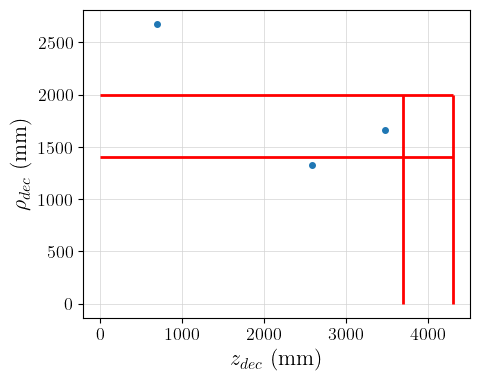

In [92]:
plt.scatter(zdec,rhodec)
plt.hlines(y=[1.4*1e3,2.0*1e3],xmin=0,xmax=4.3*1e3,colors='red')
plt.vlines(x=[3.7*1e3,4.3*1e3],ymin=0,ymax=2.0*1e3,colors='red')
# plt.vlines(x=2.0,ymin=3.7,ymax=4.3)
plt.ylabel(r'$\rho_{dec}$ (mm)')
plt.xlabel(r'$z_{dec}$ (mm)')
plt.show()

### Filter event

In [93]:
for z,rho,t,ievt in zip(zdec,rhodec,tdec,ievList):
    if z/1e3 > 4.3: continue
    if rho/1e3 > 2.0: continue
    if (z/1e3 < 1.4) and (rho/1e3 < 1.4):
        continue
    print(t*1e9,z/1e3,rho/1e3,ievt)
    

24.040479829068317 3.481759765625 1.6588588760125584 1469
23.326329312567395 2.579785400390625 1.3222477913665367 3069


### Check event

In [ ]:
f = ROOT.TFile(file,'read')
tree = f.Get("Delphes")
tree.GetEntry(1469)


# Get parton level MET
llps = list(tree.llpParticles)
invisibles = [p for p in tree.llpDirectDaughters 
                if abs(p.PID) == 4000022]
visibles =  [p for p in tree.llpDirectDaughters 
                if abs(p.PID) != 4000022]
invisibles = sorted(invisibles, key = lambda p: p.M1)
pInvTot = np.zeros(4)
pISR = np.zeros(4)
for illp,llp in enumerate(llps):
    pLLP = np.array([llp.Px,llp.Py,
                        llp.Pz,llp.E])
    pISR -= pLLP
    daughter = invisibles[illp]
    decayTime = daughter.T
    decayPosition = np.array([daughter.X,daughter.Y,daughter.Z])
    print(f'PID = {llp.PID}, t_decay (ns) = {decayTime*1e9:1.2f}, z_decay (m) = {decayPosition[2]/1e3:1.2f}, rho_dec (m) = {np.linalg.norm(decayPosition[:2])/1e3:1.2f}')
    if decayTime < 15e-9: # if LLP decays on-time, add its daughter momentum
        pInv = np.array([daughter.Px,daughter.Py,
                            daughter.Pz,daughter.E])
    else: # add the LLP momentum
        pInv = pLLP
    # print(f'  pLLP = {pLLP}')
    # print(f'  pInv = {pInv}')
    pInvTot += pInv
pISR[3] = np.linalg.norm(pISR[:3])
metParton = np.linalg.norm(pInvTot[:2])
c_light = 2.99792458e8
print(f'{len(tree.HLTTowerDelayed)} final towers')
for tower in tree.HLTTowerDelayed:
    t = tower.T
    r = np.array([tower.X,tower.Y,tower.Z])
    eta = tower.Eta
    phi = tower.Phi
    t_readout = t- np.linalg.norm(r)/c_light
    print(f'E = {tower.E:1.2f}, t(s) = {t:1.2e}, t(readout)(s) = {t_readout:1.2e}, had = {tower.Ehad:1.2f}, em = {tower.Eem:1.2f}')
    etot = 0.0
    for p in tower.Particles:
        etot += p.E
        position = np.array([p.X,p.Y,p.Z])
        zdec.append(np.abs(decayPosition[2]))
        rhodec.append(np.linalg.norm(decayPosition[:2]))
        print(f'PID= {p.PID}, E = {p.E:1.2f}, t (ns) ={p.T*1e9:1.2f}, |z| (m) = {position[2]/1e3:1.2f}, rho (m) = {np.linalg.norm(position[:2])/1e3:1.2f}')
    print(f' E = {etot:1.2f}')


print(f'{len(tree.ETowerDelayed)} ECAL towers')
print(f'{len(tree.HTowerDelayed)} HCAL towers')
# for tower in tree.HLTTowerDelayed:
#     t = tower.T
#     r = np.array([tower.X,tower.Y,tower.Z])
#     eta = tower.Eta
#     phi = tower.Phi
#     t_readout = t- np.linalg.norm(r)/c_light
#     print(f'E = {tower.E:1.2f}, t(s) = {t:1.2e}, t(readout)(s) = {t_readout:1.2e}, had = {tower.Ehad:1.2f}, em = {tower.Eem:1.2f}')
#     for p in tower.Particles:
#         position = np.array([p.X,p.Y,p.Z])
#         zdec.append(np.abs(decayPosition[2]))
#         rhodec.append(np.linalg.norm(decayPosition[:2]))
#         print(p.PID,f' t (ns) ={p.T*1e9:1.2f}, |z| (m) = {position[2]/1e3:1.2f}, rho (m) = {np.linalg.norm(position[:2])/1e3:1.2f}')


f.Close()

PID = 4000023, t_decay (ns) = 36.74, z_decay (m) = 2.45, rho_dec (m) = 1.85
PID = -4000023, t_decay (ns) = 24.04, z_decay (m) = 3.48, rho_dec (m) = 1.66
1 final towers
E = 85.81, t(s) = 3.71e-08, t(readout)(s) = 2.64e-08, had = 85.81, em = 0.00
-211  t (ns) =36.74, |z| (m) = 2.45, rho (m) = 1.85
2212  t (ns) =36.74, |z| (m) = 2.45, rho (m) = 1.85
-2212  t (ns) =36.74, |z| (m) = 2.45, rho (m) = 1.85
321  t (ns) =36.74, |z| (m) = 2.45, rho (m) = 1.85
-11  t (ns) =36.74, |z| (m) = 2.45, rho (m) = 1.85
211  t (ns) =36.79, |z| (m) = 2.47, rho (m) = 1.86
22  t (ns) =36.74, |z| (m) = 2.45, rho (m) = 1.85
2212  t (ns) =37.61, |z| (m) = 2.64, rho (m) = 1.99
-2212  t (ns) =37.21, |z| (m) = 2.55, rho (m) = 1.93
-211  t (ns) =36.74, |z| (m) = 2.45, rho (m) = 1.85
11  t (ns) =36.82, |z| (m) = 2.47, rho (m) = 1.87
22  t (ns) =36.79, |z| (m) = 2.47, rho (m) = 1.86
22  t (ns) =36.79, |z| (m) = 2.47, rho (m) = 1.86
22  t (ns) =37.61, |z| (m) = 2.64, rho (m) = 1.99
22  t (ns) =37.61, |z| (m) = 2.64, rho

In [95]:
#   set Radius 1.4
#   set RadiusMax 2.0
#   set HalfLength 3.7
#   set HalfLengthMax 4.3
  